# Multiple Regression | PyTorch

## About Dataset

Link to dataset: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009  


The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones). 


Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol


Output variable (based on sensory data):
1. quality (score between 0 and 10) 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv("../../../data/Tabular/winequality-red.csv")

## Pre-processing

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


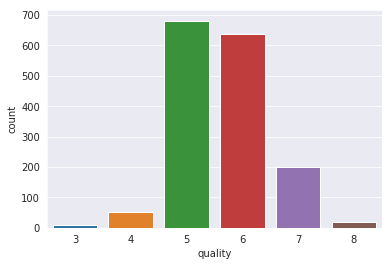

In [5]:
sns.countplot(x = 'quality', data=df)

In [6]:
# PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0.

quality_mapper = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

df['quality'].replace(quality_mapper, inplace=True)

In [7]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

## Define custom dataset

In [9]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))
test_data = testData(torch.FloatTensor(X_test))

## Define Neural Network Architecture

In [12]:
class multiRegression(nn.Module):
    def __init__(self, num_features):
        super(multiRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        
        return (x)        

In [13]:
num_feature = len(X.columns)

EPOCHS = 1000
BATCH_SIZE = 32

model = multiRegression(num_feature)
criterion = nn.MSELoss()

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
for epoch in range(EPOCHS):
    for X_batch, y_batch in train_loader:
        model.zero_grad()
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: MSE Loss = {loss.data}')

Epoch 0: MSE Loss = 5.476914882659912
Epoch 100: MSE Loss = 0.5272329449653625
Epoch 200: MSE Loss = 0.09655549377202988
Epoch 300: MSE Loss = 0.14758823812007904
Epoch 400: MSE Loss = 0.24257589876651764
Epoch 500: MSE Loss = 0.1523609757423401
Epoch 600: MSE Loss = 0.298722505569458
Epoch 700: MSE Loss = 0.11322832107543945
Epoch 800: MSE Loss = 0.10364456474781036
Epoch 900: MSE Loss = 0.10400708764791489


In [15]:
test_loader = DataLoader(dataset=test_data, batch_size=1)
y_pred = []

with torch.no_grad():
    for X_batch in test_loader:
        y_test_pred = model.predict(X_batch)
        y_pred.append(y_test_pred.numpy())

In [16]:
y_pred = pd.DataFrame(np.reshape(y_pred, -1))

In [17]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.6436435660105784
R^2 : 0.1086418428145276
